In [26]:
from pyspark.sql.functions import mean, udf, col, round, isnan, when, count
from pyspark.sql.types import DoubleType
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
spark_session  = SparkSession.builder\
                        .enableHiveSupport()\
                        .getOrCreate()

spark_session.conf.set("spark.executor.memory", '8g')
spark_session.conf.set('spark.executor.cores', '13')
spark_session.conf.set('spark.cores.max', '13')
spark_session.conf.set("spark.driver.memory",'8g')
sc = spark_session.sparkContext

## import csv files into spark dataframes
Note: both files contain records from all 5 boroughs

In [28]:
df1 = spark.read.csv('data/pluto.csv', header=True)
df2 = spark.read.csv('data/pluto_18v1.csv', header=True)
df3 = spark.read.csv('data/pluto_17v11.csv', header=True)

In [29]:
df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])
df3 = df3.select([col(A).alias(A.lower()) for A in df3.schema.names])

In [5]:
double_columns = ['bldgarea', 'facilfar',
                  'residfar', 'commfar', 'numbldgs', 'numfloors', 'bldgdepth', 
                  'bldgfront', 'lotdepth', 'lotfront', 
                  'exempttot', 'exemptland',  'assessland', 'assesstot', 'builtfar']

In [31]:
cols = df2.columns

In [32]:
df1 = df1.select(cols)
df2 = df2.select(cols)
df3 = df3.select(cols)

## Type Conversion

In [33]:
for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df3 = df3.withColumn(A, round(col(A).cast(DoubleType()), 2))

## Count Null and 0

In [34]:
null_1 = df1.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df1.columns]).toPandas()

In [35]:
null_2 = df2.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df2.columns]).toPandas()

In [36]:
null_3 = df3.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df3.columns]).toPandas()

In [37]:
null_all = pd.concat([null_3, null_2, null_1])
null_change = null_all.pct_change()

In [38]:
null_change.iloc[1,:].sort_values(ascending=False)[0:10]

bsmtcode      0.992375
lotfront      0.319816
lotarea       0.277077
lotdepth      0.238225
lottype       0.072540
ownername     0.060815
zonedist1     0.053299
exempttot     0.038038
exemptland    0.035908
yearbuilt     0.023502
Name: 0, dtype: float64

In [39]:
null_change.iloc[2,:].sort_values(ascending=False)[0:10]

plutomapid                    inf
cd                            inf
zonemap                 37.367589
zonedist1               22.766265
splitzone               19.211066
healthcenterdistrict     6.539503
schooldist               6.237099
policeprct               5.788618
council                  5.673327
healtharea               5.052552
Name: 0, dtype: float64

In [42]:
null_all.index = ['17v11', '18v1', '18v2']
null_all

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version
17v11,0,1,0,0,4322,21037,3051,3105,4369,3784,...,843575,1485,1485,850496,770520,770520,0,824654,793595,0
18v1,0,1,0,0,4074,20549,2771,3003,4154,3521,...,843698,1222,1222,849823,768685,768684,0,824650,793594,0
18v2,0,0,0,20040,20040,20040,20054,20040,20055,20099,...,843179,1216,0,849599,767331,810016,297,824148,793140,0


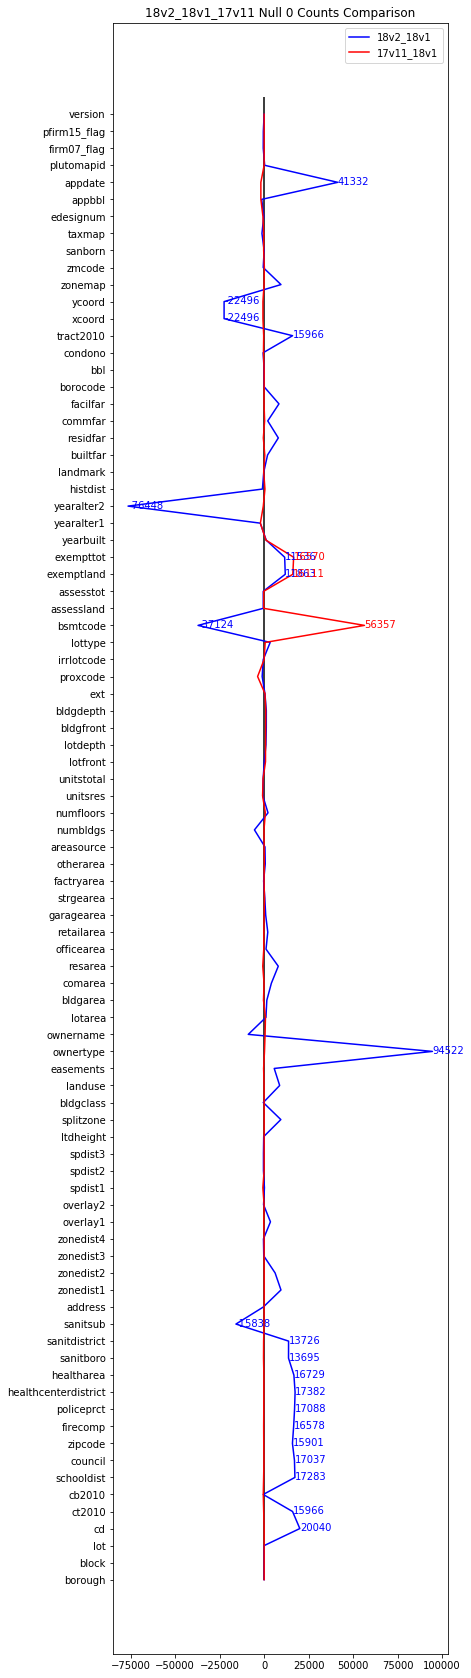

In [65]:
plt.figure(figsize=(6, 30))

difference1 = null_all.iloc[1, :]-null_all.iloc[0, :]
difference2 = null_all.iloc[2, :]-null_all.iloc[1, :]

plt.plot(difference2, range(87), label = '18v2_18v1', color = 'blue')
plt.plot(difference1, range(87), label = '17v11_18v1', color = 'red')
plt.vlines(0, 0, 87) #0 reference line

for i in range(87):
    if abs(difference2[i]) >= 10000:
        plt.text(x = difference2[i] , y = i - 0.15, s = '{}'.format(difference2[i]), size = 10, color = 'blue')
    else: 
        pass
    
for i in range(87):
    if abs(difference1[i]) >= 10000:
        plt.text(x = difference1[i] , y = i-0.15, s = '{}'.format(difference1[i]), size = 10, color = 'red')
    else: 
        pass
    
plt.yticks(range(87), null_all.columns, rotation='horizontal')
plt.title('18v2_18v1_17v11 Null 0 Counts Comparison')
plt.legend()
plt.savefig('18v2_18v1_17v11_Null0_Comparison.png', bbox_inches='tight')
plt.show()

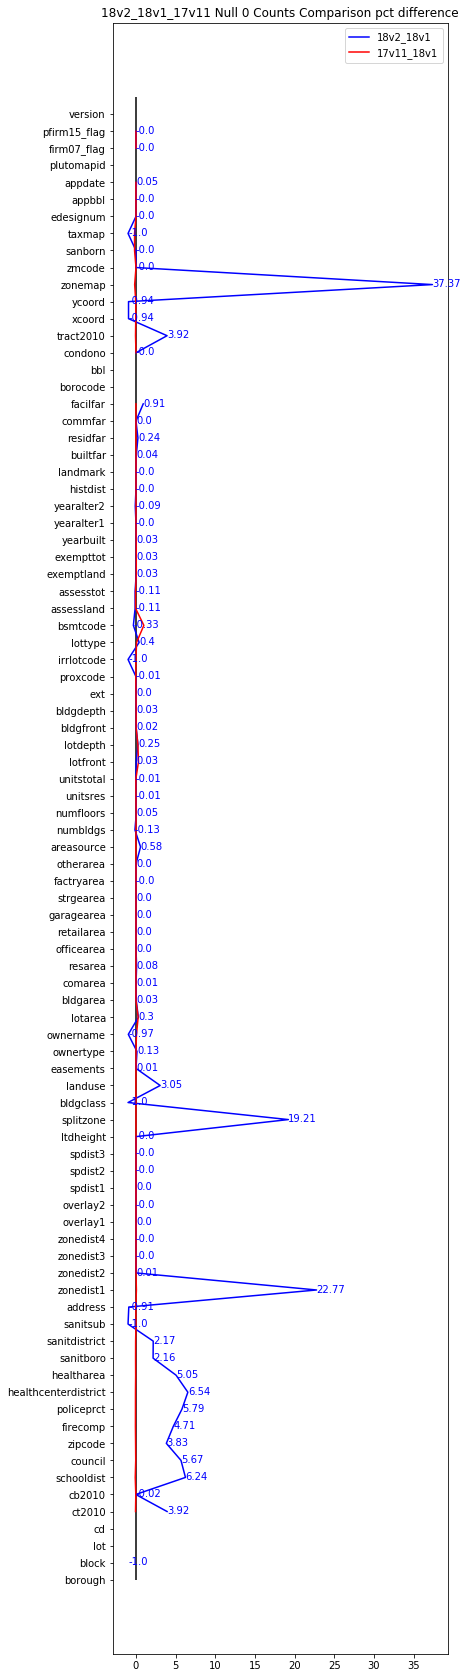

In [64]:
plt.figure(figsize=(6, 30))

plt.plot(null_change.iloc[2,:], range(87), label = '18v2_18v1', color = 'blue')
plt.plot(null_change.iloc[1,:], range(87), label = '17v11_18v1', color = 'red')
plt.vlines(0, 0, 87) #0 reference line

for i in range(87):
    if abs(null_change.iloc[2,i]) <= 100:
        plt.text(x = null_change.iloc[2,i] , y = i - 0.15, s = '{}'.format(np.round(null_change.iloc[2,i], 2)), size = 10, color = 'blue')
    else: 
        pass
    
plt.yticks(range(87), null_all.columns, rotation='horizontal')
plt.title('18v2_18v1_17v11 Null 0 Counts Comparison pct difference')
plt.legend()
plt.savefig('18v2_18v1_17v11_Null0_Comparison_pct.png', bbox_inches='tight')
plt.show()